* [ArXiv](https://arxiv.org/pdf/2312.01020)
* [GitHub](https://github.com/Yuanzhe-Jia/ResNLS)

![Architecture](./figures/293321962-0c159c6c-3dd4-451c-aa4d-2277cc8a7ae5.png)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics

import os
import sys
import math
import numpy as np
import pandas as pd
from scipy.stats import norm

In [ ]:
import mlflow
from mlflow.models import infer_signature

import seaborn as sns
from tqdm.notebook import tqdm, trange

sys.path.append('../')
from src.preprocess import prepare_time_series_data_presplit, create_sequences
from src.train import run_training, EarlyStopper

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_FACTORS = 1
NUM_EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
LR_DECAY = 0.8
LR_PATIENCE = 4
PATIENCE = 5
MIN_DELTA = 1e-5

In [4]:
sns.set_theme('paper', rc={'figure.figsize': (16, 4)})

torch.manual_seed(42)

training_params = {
    'num_epochs': NUM_EPOCHS,
    'batch_size': BATCH_SIZE,
    'learning_rate': LEARNING_RATE,
    'lr_decay': LR_DECAY,
    'lr_patience':LR_PATIENCE,
    'patience': PATIENCE,
    'min_delta': MIN_DELTA
}

data_params = {
    'lookback': 5,
    'horizon': 1
}

model_params = {
    'n_hidden': 32,
    'kernel_size': 3,
    'stride': 1,
    'padding': 1,
    'eps': 1e-5,
    'dropout': 0.2
}

mlflow.set_experiment("Stock Market Predictions")
mlflow.start_run(run_name="ResNLS")
mlflow.log_params({**training_params, **data_params, **model_params})

In [5]:
DATA_FILE = '../data/SSEC.csv'
quote_type = 'Close'
df = pd.read_csv(DATA_FILE, index_col='Date')

mlflow.log_input(mlflow.data.from_pandas(df[[quote_type]], name=os.path.basename(DATA_FILE)))

In [6]:
data_train = df.loc['2011-01-01':'2020-12-31'][[quote_type]].values
data_val = df.loc['2021-01-01':'2021-12-31'][[quote_type]].values
data_test = df.loc['2022-01-01':][[quote_type]].values

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_size = len(data_train)
val_size = len(data_val)
test_size = len(data_test)

mlflow.log_params({'train_size': train_size, 'val_size': val_size, 'test_size': test_size})

(X_train, y_train), (X_val, y_val), (X_test, y_test) = prepare_time_series_data_presplit(
    data_train, data_val, data_test, scaler=scaler, **data_params
)

\begin{gather*}
N = \textrm{batch\_size} \\
L = \textrm{sequence length} = \textrm{lookback} \\
H_{in} = \textrm{input\_size} = \textrm{num\_factors} \\
H_{out} = \textrm{output\_size} = \textrm{horizon} \\
X \sim (N,L,H_{in}),\ y \sim (N,H_{out}) \\
\end{gather*}

In [8]:
X_train.size(), y_train.size(), X_val.size(), y_val.size(), X_test.size(), y_test.size()

(torch.Size([2427, 5, 1]),
 torch.Size([2427, 1]),
 torch.Size([238, 5, 1]),
 torch.Size([238, 1]),
 torch.Size([237, 5, 1]),
 torch.Size([237, 1]))

In [9]:
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False)

$ L_{out​}= \left. \left\lfloor \frac{L_{in}​+2×\textrm{padding}−\textrm{dilation}×(\textrm{kernel\_size}−1)−1​}{\textrm{stride}}+1 \right\rfloor \right\vert_{\textrm{kernel\_size}=3, \, \textrm{padding} = 1,\, ...} = L_{in}$

In [10]:
class ResNLS(nn.Module):

    def __init__(self, n_input, n_output, n_hidden = 32, kernel_size=3, stride=1, padding=1, eps=1e-5, dropout = 0.2):
        super(ResNLS, self).__init__()

        # intialise weights of the attention mechanism
        self.weight = nn.Parameter(torch.zeros(1))

        # intialise cnn structure
        self.cnn = nn.Sequential(           
            nn.Conv1d(n_input, n_hidden, kernel_size, stride, padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden, eps),
            nn.Dropout(dropout),

            nn.Conv1d(n_hidden, n_hidden, kernel_size, stride, padding),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(n_hidden, eps),
        )
        self.linear = nn.Linear(n_hidden, n_input)
        
        # intialise lstm structure
        self.lstm = nn.LSTM(n_input, n_hidden, batch_first=True, bidirectional=False)
        self.final_linear = nn.Linear(n_hidden, n_output)


    def forward(self, x):
        # CNN expects input of shape (N,C_in​,L) = (batch_size, num_factors, lookback)
        cnn_output = self.cnn(x.transpose(-1, 1))
        cnn_output = self.linear(cnn_output.transpose(-1,1))

        x = x + self.weight * cnn_output

        # LSTM expects input of shape (N,L,H_in) = (batch_size, lookback, num_factors)
        out, _  = self.lstm(x)
        y_hat = self.final_linear(out[:,-1,:])

        return y_hat

In [11]:
model = ResNLS(n_input=1, n_output=data_params['horizon'], **model_params).to(DEVICE)
criterion = nn.MSELoss().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)

mlflow.log_param('criterion', type(criterion).__name__)
mlflow.log_param('optimizer', type(optimizer).__name__)

'Adam'

In [12]:
metric = nn.L1Loss().to(DEVICE)
mlflow.log_param('metric', type(metric).__name__)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=LR_DECAY, patience=LR_PATIENCE)
mlflow.log_param('scheduler', type(scheduler).__name__)

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=MIN_DELTA)

In [13]:
train_losses, val_losses = run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=NUM_EPOCHS,
    metric=metric,
    scheduler=scheduler,
    early_stopper=early_stopper
)

  0%|          | 0/100 [00:00<?, ?epoch/s]

  0%|          | 0/38 [00:00<?, ?batch/s]

  0%|          | 0/4 [00:00<?, ?batch/s]

Early stopping at epoch 17


<Axes: title={'center': 'Losses'}>

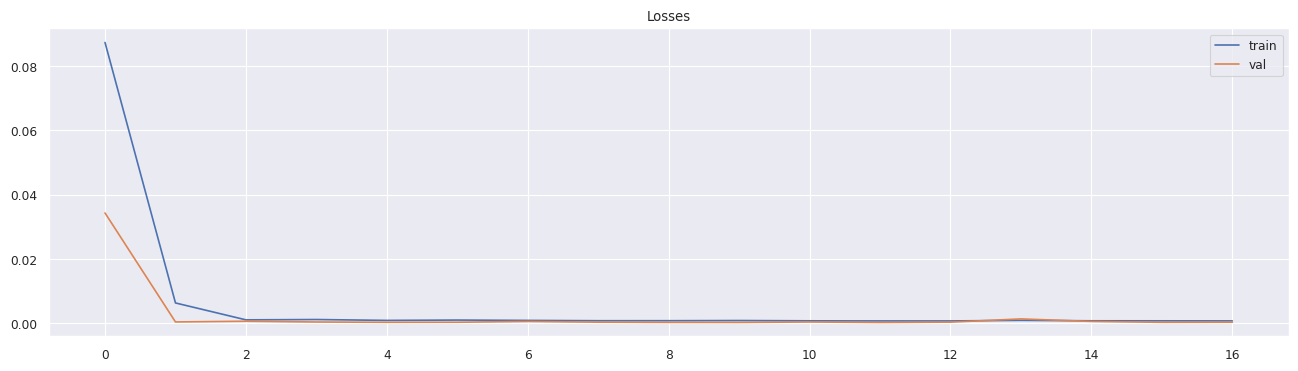

In [14]:
pd.DataFrame(data={'train': train_losses[::len(train_losses)//len(val_losses)], 'val': val_losses}).plot(title='Losses')

Registered model 'ResNLS' already exists. Creating a new version of this model...
Created version '2' of model 'ResNLS'.


<Axes: xlabel='Date'>

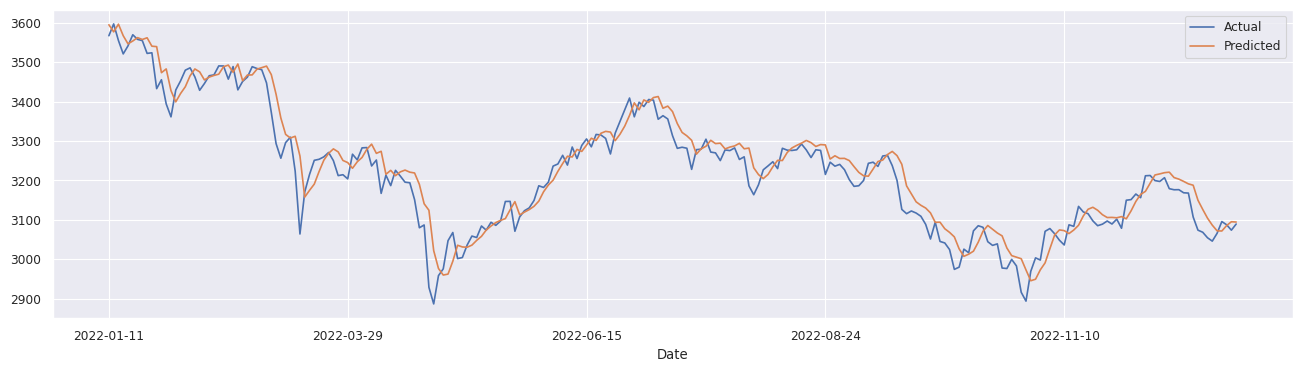

In [15]:
if os.path.exists(f'../models/{type(model).__name__}.pt'):    
    model.load_state_dict(torch.load(f"../models/{type(model).__name__}.pt"))
model.eval()
with torch.no_grad():
    X_test = X_test.to(DEVICE)
    y_pred = model(X_test)

y_pred_inv = scaler.inverse_transform(y_pred.cpu().detach().numpy())[:,0]
y_test_inv = scaler.inverse_transform(y_test.cpu().detach().numpy())[::data_params['horizon'],0]

mlflow.pytorch.log_model(
    registered_model_name="ResNLS",
    artifact_path="ResNLS",
    pytorch_model=model,
    input_example=X_test.cpu().detach().numpy(),
    signature=infer_signature(X_test.cpu().detach().numpy(), y_pred.cpu().detach().numpy())
)

pd.DataFrame([y_test_inv, y_pred_inv], index=['Actual', 'Predicted'], columns=df.index[-len(X_test):]).T.plot()

In [16]:
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(y_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_pred_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae', mae)
mlflow.log_metric('test_mse', mse)
mlflow.log_metric('test_rmse', rmse)

print(f"Test MAE: {mae:.4f}  Test MSE: {mse:.4f} Test RMSE: {rmse:.4f}")

Test MAE: 33.1041  Test MSE: 2015.5592 Test RMSE: 44.8950


<Axes: xlabel='Date'>

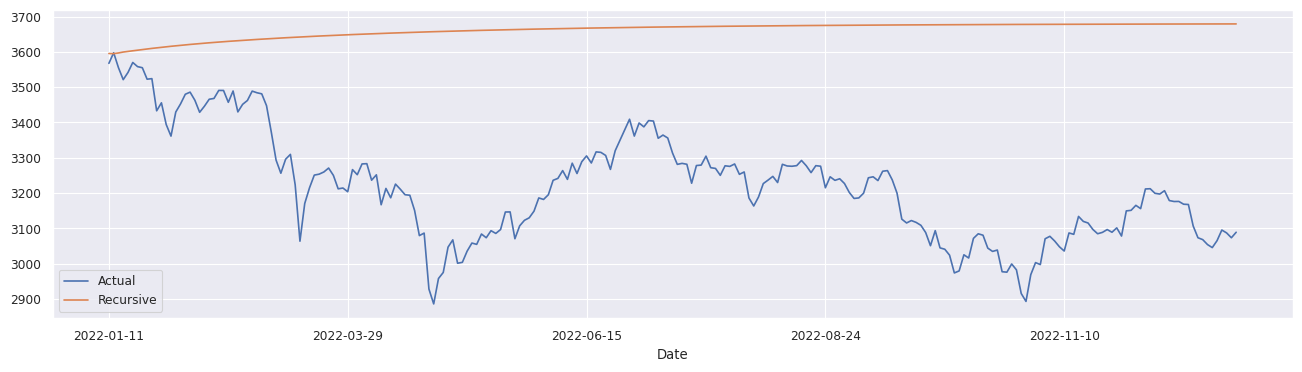

In [17]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
model.eval()
y_recursive = []

# Start with the first element of X_test
current_input = X_test[0].unsqueeze(0)

with torch.no_grad():
    for _ in range(len(X_test)):
        output = model(current_input).unsqueeze(-1)
        y_recursive.append(output[:,[0],:].cpu().numpy())

        # Prepare the next input by appending the prediction to the current input and removing the oldest value
        current_input = torch.cat((current_input[:, 1:, :], output[:,[0],:]), dim=1)

y_recursive = np.concatenate(y_recursive, axis=1).squeeze()
y_recursive_inv = scaler.inverse_transform(y_recursive.reshape(-1, 1)).flatten()

pd.DataFrame([y_test_inv, y_recursive_inv], index=['Actual', 'Recursive'], columns=df.index[-len(X_test):]).T.plot()

In [18]:
assert NUM_FACTORS == 1, "Recursive prediction only works with a single factor"
# Calculate MAE, MSE, and RMSE
mae = metrics.mean_absolute_error(y_recursive_inv, y_test_inv)
mse = metrics.mean_squared_error(y_recursive_inv, y_test_inv)
rmse = metrics.mean_squared_error(y_recursive_inv, y_test_inv) ** 0.5

# Log the metrics to mlflow
mlflow.log_metric('test_mae_recursive', mae)
mlflow.log_metric('test_mse_recursive', mse)
mlflow.log_metric('test_rmse_recursive', rmse)
mlflow.end_run()

print(f"Recursive MAE: {mae:.4f} Recursive MSE: {mse:.4f} Recursive RMSE: {rmse:.4f}")

🏃 View run ResNLS at: http://localhost:5000/#/experiments/1/runs/43904a631dfd4f19bf827944bf4da4b5
🧪 View experiment at: http://localhost:5000/#/experiments/1
Recursive MAE: 443.7911 Recursive MSE: 224865.2500 Recursive RMSE: 474.1996


<Axes: xlabel='Date'>

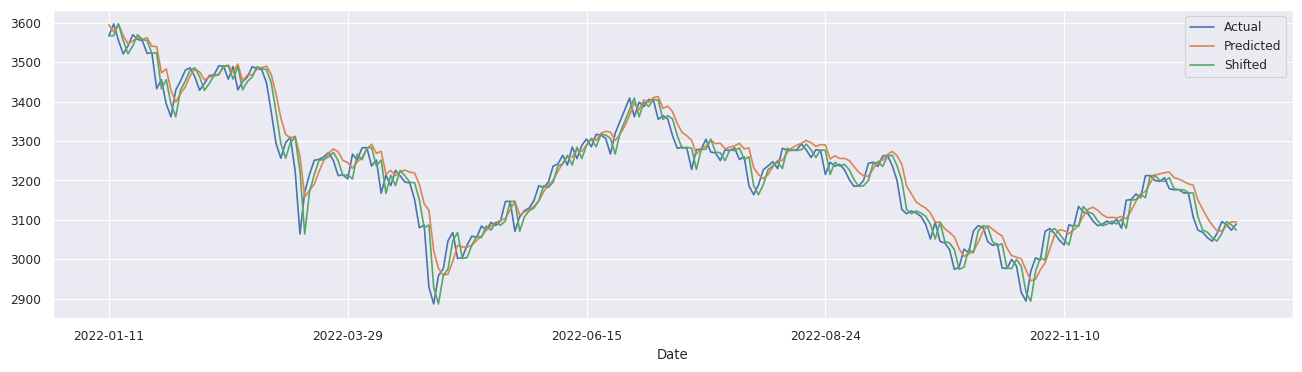

In [19]:
#Compare to the naive forecast
shifted_y_test_inv = np.roll(y_test_inv, 1).flatten()
shifted_y_test_inv[0] = y_test_inv[0]

pd.DataFrame([y_test_inv, y_pred_inv, shifted_y_test_inv], index=['Actual', 'Predicted', 'Shifted'], columns=df.index[-len(X_test):]).T.plot()

In [20]:
# Naive predictions
mae = metrics.mean_absolute_error(shifted_y_test_inv, y_test_inv)
mse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv)
rmse = metrics.mean_squared_error(shifted_y_test_inv, y_test_inv) ** 0.5

print(f"Naive MAE: {mae:.4f}  Naive MSE: {mse:.4f} Naive RMSE: {rmse:.4f}")

Naive MAE: 26.2390  Naive MSE: 1307.3947 Naive RMSE: 36.1579


<Axes: xlabel='Date'>

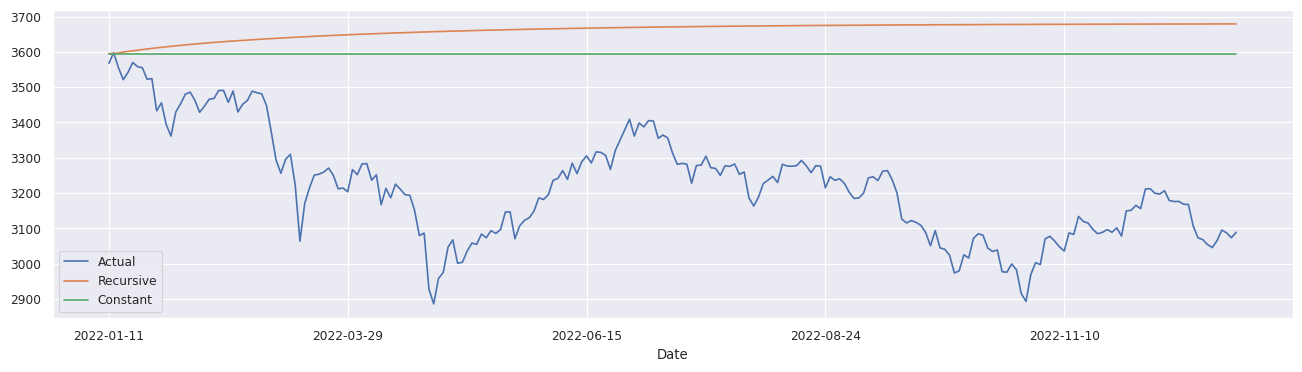

In [21]:
const_pred_inv = np.full_like(y_test_inv.flatten(), scaler.inverse_transform(X_test[0].cpu().numpy().flatten().reshape(-1, 1))[-1][0])

pd.DataFrame([y_test_inv, y_recursive_inv, const_pred_inv], index=['Actual', 'Recursive', 'Constant'], columns=df.index[-len(X_test):]).T.plot()

In [22]:
# Constant prediction
mae = metrics.mean_absolute_error(const_pred_inv, y_test_inv)
mse = metrics.mean_squared_error(const_pred_inv, y_test_inv)
rmse = metrics.mean_squared_error(const_pred_inv, y_test_inv) ** 0.5

print(f"Constant MAE: {mae:.4f} Constant MSE: {mse:.4f} Constant RMSE: {rmse:.4f}")

Constant MAE: 375.8393 Constant MSE: 164288.3906 Constant RMSE: 405.3250


<Axes: xlabel='Date'>

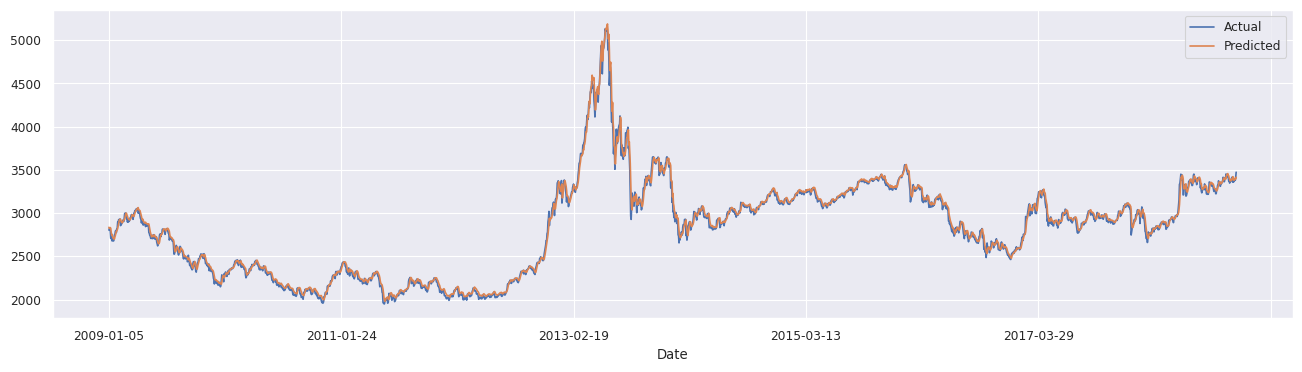

In [23]:
# Get predictions on the training dataset to check for overfitting
model.eval()
with torch.no_grad():
    X_train = X_train.to(DEVICE)
    y_train_pred = model(X_train)

y_train_pred_inv = scaler.inverse_transform(y_train_pred.cpu().detach().numpy())[:,0]
y_train_inv = scaler.inverse_transform(y_train.cpu().detach().numpy())[:,0]

pd.DataFrame([y_train_inv, y_train_pred_inv], index=['Actual', 'Predicted'], columns=df.index[:len(X_train)]).T.plot()

In [24]:
# Evaluate the model on the training dataset
mae = metrics.mean_absolute_error(y_train_pred_inv, y_train_inv)
mse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv)
rmse = metrics.mean_squared_error(y_train_pred_inv, y_train_inv) ** 0.5

print(f"Train MAE: {mae:.4f} Train MSE: {mse:.4f} Train RMSE: {rmse:.4f}")

Train MAE: 34.7975 Train MSE: 2707.5220 Train RMSE: 52.0339


<Axes: xlabel='Date'>

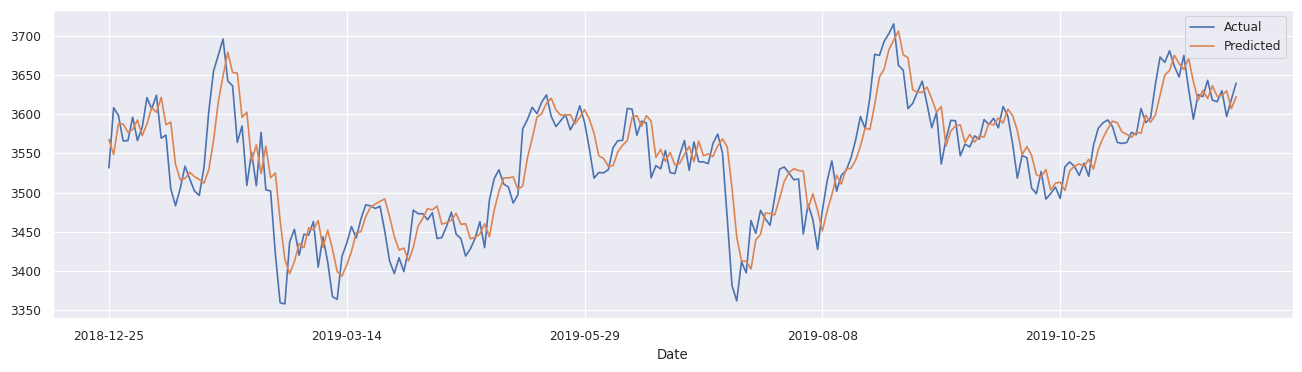

In [25]:
# Get predictions on the validation dataset to compare with the original papers results
model.eval()
with torch.no_grad():
    X_val = X_val.to(DEVICE)
    y_val_pred = model(X_val)

y_val_pred_inv = scaler.inverse_transform(y_val_pred.cpu().detach().numpy())[:,0]
y_val_inv = scaler.inverse_transform(y_val.cpu().detach().numpy())[:,0]

pd.DataFrame([y_val_inv, y_val_pred_inv], index=['Actual', 'Predicted'], columns=df.index[len(X_train):len(X_train)+len(X_val)]).T.plot()

In [26]:
# Evaluate the model on the validation dataset
mae = metrics.mean_absolute_error(y_val_pred_inv, y_val_inv)
mse = metrics.mean_squared_error(y_val_pred_inv, y_val_inv)
rmse = metrics.mean_squared_error(y_val_pred_inv, y_val_inv) ** 0.5

print(f"Validation MAE: {mae:.4f} Validation MSE: {mse:.4f} Validation RMSE: {rmse:.4f}")

Validation MAE: 25.7626 Validation MSE: 1157.6825 Validation RMSE: 34.0247
